### Allele Frequency Trajectories

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
from matplotlib import gridspec
from matplotlib.dates import date2num
from datetime import date

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)
rcParams['axes.linewidth'] = 0.2  # Set the Default Size of the Boundary for small 2.25in width figures
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

sys.path.append("./python3/")
from manipulate_fasta import fasta_iter_raw, fasta_iter

Current machine: compute-a-16-169.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [2]:
def load_merged_df(var_path="./output/tables/derived_common_snps.tsv",
                   meta_path="./data/apr20/metadata.tsv",
                   epi_col = "gisaid_epi_isl"):
    """Load variant df and meta df, and merge on epi_col"""
    df = pd.read_csv(var_path, sep="\t")
    df[epi_col] = df["iid"].str.split("|").str[1]  # Split out the EPI ID
    df_meta = pd.read_csv(meta_path, sep="\t")
    df1 = pd.merge(df, df_meta, on=epi_col)
    print(f"Merged to {len(df1)}/{len(df)} Individuals")
    return df1

### Load the variant Data

In [4]:
df1 = load_merged_df(var_path="./output/tables/derived_common_snps.tsv",
                     meta_path="./data/may20/metadata.tsv")
df1 = df1[~(df1["date"]=="2020-02-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-03-XX")].copy() # Throw out garbage data
df1 = df1[~(df1["date"]=="2020-01-01")].copy()
df1["date1"] =  pd.to_datetime(df1["date"]) # New Sort Column
print(f"Thrown out data with inaccurate dates, now: {len(df1)}")

Merged to 17107/17148 Individuals
Thrown out data with inaccurate dates, now: 17083


In [7]:
### Experiments to establish what is missing [Only run if many individuals do not match meta]
df = pd.read_csv("./output/tables/derived_common_snps.tsv", sep="\t")
idx =[iid not in df1["iid"].values for iid in df["iid"]]

cts = df[idx]["iid"].str.split("/").str[1]
cts.value_counts()

#df_meta = pd.read_csv("./data/may20/metadata.tsv", sep="\t")
#found = df_meta["gisaid_epi_isl"].str.contains("433498")
#np.sum(found)

China          17
USA            17
Germany        12
Netherlands     6
Wuhan           5
Canada          2
Belgium         2
Switzerland     1
Korea           1
France          1
South Korea     1
Name: iid, dtype: int64

### Plot Cumulative Frequency

In [8]:
df2 = df1.copy()
pos= f"23402"
flip = True

df2 = df2[df2["date1"]!="2020-01-01"]
df2 = df2.sort_values(by="date1")
df2 = df2[df2['host']=="Human"]
print(f"Human Samples: {len(df2)}")
derived = df2[pos]

if flip:
    derived= ~derived

dts = df2["date1"]
cum_count = np.arange(len(df2))+1
cum_der = np.cumsum(derived)
all_freq = cum_der / cum_count

Human Samples: 16983


Saved to ./figures/dumpster/all_freq_full.png


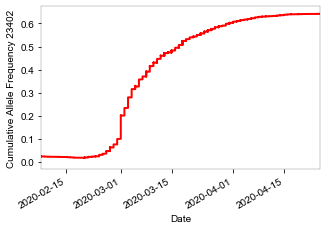

In [9]:
savepath="./figures/dumpster/all_freq_full.png"

plt.figure(figsize=(5,3))
ax=plt.gca()
ax.plot(dts, all_freq, lw=2, c="r")

ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
ax.set_xlabel("Date")
plt.xticks(rotation=30, ha='right')
#ax.set_xlim([date("2020-02-01"), date("2020-04-01")])
ax.set_xlim([date(2020, 2, 8), date(2020, 4, 25)])
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=200)
    print(f"Saved to {savepath}")

plt.show()

In [10]:
def plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                         figsize=(12,4), pos= f"23402", flip=False, min_cases = 10, col = "country",
                         countries = ["Netherlands", "United Kingdom", "France", "Belgium", 
                                      "Switzerland", "Germany", "Luxembourg", "USA", "Canada", "Australia", "China"]):
    plt.figure(figsize=figsize)
    ax=plt.gca()

    for ctry in countries:
        df_t = df2[df2[col]==ctry]

        derived = df_t[pos]
        if flip:
            derived = ~derived
        dts = df_t["date1"]
        cum_count = np.arange(len(df_t))+1
        cum_der = np.cumsum(derived)
        all_freq = cum_der / cum_count

        ax.plot(dts[min_cases:], all_freq[min_cases:], label=ctry)

    #plt.plot(date, cum_count)
    ax.set_ylabel(f"Cumulative Allele Frequency {23402}")
    ax.set_xlabel("Date")
    ax.set_xlim([date(2020, 2, 15), date(2020, 5, 15)])
    ax.legend(loc = "upper right")
    plt.xticks(rotation=30, ha='right')

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/dumpster/all_freq_country_april.png


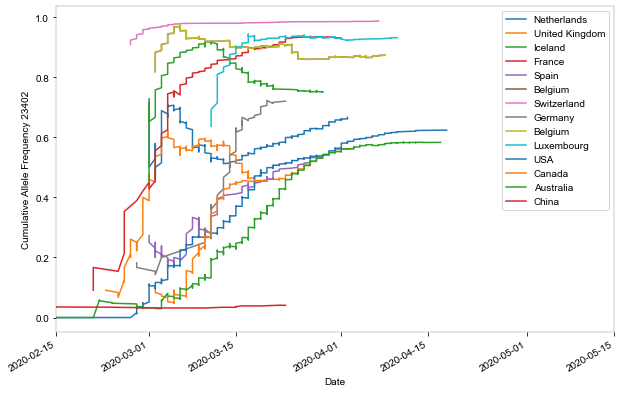

In [11]:
countries = ["Netherlands", "United Kingdom", "Iceland", "France", "Spain", "Belgium", 
                                  "Switzerland", "Germany", "Belgium", "Luxembourg", "USA", "Canada", "Australia", 
                                  "China"]

#countries = ["Wisconsin"]

plot_freq_traj_group(figsize=(10,6), savepath="./figures/dumpster/all_freq_country_april.png",
                     pos= f"3036", min_cases = 10, col = "country",
                     countries = countries, flip=True)

Saved to ./figures/dumpster/all_freq_country_april.png


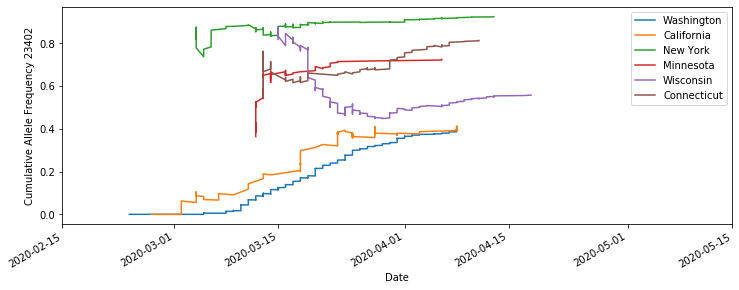

In [128]:
countries = ["Washington", "Reykjavik", "England", "Wales",
             "Auvergne-Rhône-Alpes", "North Brabant", "Ontario", "Portugal",
             "Minnesota", "New York", "California", "New York"]
countries=["Washington", "California", "New York", "Minnesota", "Wisconsin", "Connecticut"]

plot_freq_traj_group(savepath="./figures/dumpster/all_freq_country_april.png",
                     pos= f"23402", min_cases = 10, col = "division",
                     countries = countries, flip=True)

In [ ]:
df2["Ontario"].value_counts()

# Plot Diagrams

In [41]:
def plot_freq_traj_ax(ax, df, ctry, pos= f"23402", xlim=[], left=True, bottom=True, c="red", cs=["blue", "red"],
                      flip=False, min_cases = 10, col = "country", ylabel="Cumulative Frequency Derived",
                      hist=True, ylim=[], lw=3, fs_l=12, show=False, hist_bw=3, alpha=0.5,
                      ylim_hist=[0,0.15], lw_hist=0.3, hist_y_stretch=1.2,
                      txt_xy=(0.97, 0.48), savepath=""):
    plt.xticks(rotation=30, ha='right')
    df_t = df[df[col]==ctry]
    
    dts = df_t["date1"].values
    derived = df_t[pos].values.astype("bool")
    if flip:
        derived = 1 - derived
    idx = (derived == 1)  # Get index of derived dates
    
    cum_count = np.arange(len(df_t))+1
    cum_der = np.cumsum(derived)
    all_freq = cum_der / cum_count
    
    ax.set_yticks([0,0.25,0.5, 0.75])
    #plt.plot(date, cum_count)
        
    ax.set_xlim(xlim)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    #ax.legend(fontsize=fs_l)
    label = f"{ctry}\n {np.sum(derived)}/{len(derived)}"
    ax.text(txt_xy[0], txt_xy[1], label, horizontalalignment='right', zorder=10,
            verticalalignment='top', transform=ax.transAxes, fontsize=fs_l)
    ax.grid(linestyle='--', lw=0.5)
    
    if hist_bw>0:
        bins = pd.date_range(xlim[0], xlim[1])[::hist_bw]
        ax2=ax.twinx()
        ax2.set_ylim(ylim_hist)
        ax2.set_yticks([])
        n,_,_ = ax2.hist([dts[idx], dts[~idx]], range=xlim, lw=lw_hist,
                  bins=date2num(bins), ec="k", alpha=alpha, color=cs, zorder=0)
        m = hist_y_stretch * np.max(n[0]+n[1])
        ax2.set_ylim([0,m])
        
    ax.plot(dts[min_cases:], all_freq[min_cases:], label=ctry, 
            lw=lw, color=c, zorder=5) # Plot the line
    
    ### Do the labels
    if left:
        ax.set_ylabel(ylabel, color=c)
        ax.tick_params(axis='y', colors=c)
    else:
        ax.set_yticklabels([])
    
    if bottom:
        ax.set_xlabel("Date")
        
    else: 
        ax.set_xticklabels([])

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=200)
        print(f"Saved to {savepath}")
    if show:
        plt.show()

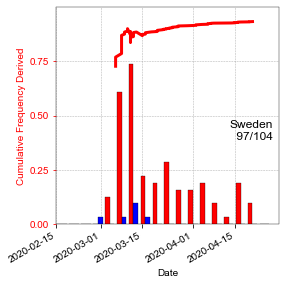

In [91]:
xlim = [date(2020, 2, 15), date(2020, 4, 30)]
ylim=[0,1]
ctry = "Sweden"

fig = plt.figure(figsize=(4,4))
ax = plt.gca()
plot_freq_traj_ax(ax, df2, ctry=ctry, xlim=xlim,
                  c="red", cs=["red", "blue"], 
                  hist_bw=4, alpha=1.0,
                  ylim=ylim, fs_l=12, flip=True)

In [ ]:
countries = list(df2["country"].value_counts()[:25].index)
countries

In [17]:
df2["country"].value_counts()[:30]

United Kingdom                      5429
USA                                 4688
Australia                           1324
Iceland                              601
Netherlands                          560
Belgium                              428
China                                420
Spain                                410
Denmark                              402
France                               247
Luxembourg                           233
Germany                              170
India                                165
Russia                               154
Canada                               143
Sweden                               104
Japan                                101
Portugal                             100
Democratic Republic of the Congo      99
Singapore                             97
Brazil                                87
Italy                                 78
Taiwan                                78
Switzerland                           75
Hong Kong       

In [63]:
def array_freqs(
    df, countries, pos= "23402", min_cases=20,
    n_col =6, n_row = 4, alpha=1.0,
    hspace = 0.08, wspace = 0.08, ylabel="Cumulative Frequency Derived",
    sgl_figsize=(3,3), lw=4, hist_bw=3,
    xlim = [date(2020, 2, 15), date(2020, 4, 30)], ylim=[0,1],
    only_first=False, col = "country", fs_l = 12, flip=False,
    txt_xy=(0.97, 0.48), ylim_hist=[0,0.15], c="red", cs = ["blue", "red"],
    
    savepath=""):
    """Make array Plot of allele Frequencies"""

    figsize = (n_col * sgl_figsize[0], n_row * sgl_figsize[1])
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(n_row, n_col)
    gs.update(hspace = hspace) # set the spacing between axes.
    gs.update(wspace = wspace)

    n=len(countries)  # Keep the original Length 
    cts = np.resize(countries, (n_row, n_col))
    #labels = np.resize(labels, (n_row, n_col))

    for i in range(n_row):
        for j in range(n_col):
            left = False
            bottom = False
            if i == len(cts)-1:
                bottom=True
            if j== 0:
                left=True
            if (i>0 or j>0) and only_first:
                continue
            #print((i,j))
            country = cts[i,j]
            if (n_col*i + j)>=n: # If no more new data to plot
                continue
            ax = plt.subplot(gs[i , j]) # The left subplot
            plot_freq_traj_ax(ax, df, ctry=country, pos=pos, xlim=xlim, ylim=ylim, fs_l=fs_l, flip=flip,
                              col = col, left=left, bottom=bottom, lw=lw, txt_xy=txt_xy, c=c, cs=cs,
                              ylim_hist=ylim_hist, hist_bw=hist_bw, alpha=alpha, min_cases=min_cases,
                              ylabel=ylabel)
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    plt.show()

In [96]:
dct_rpl = {"Democratic Republic of the Congo": "DR Congo", "United Kingdom":"UK"}
df2["country"].replace(dct_rpl, inplace=True)

countries = ["UK", "Sweden", "Netherlands", "Belgium", "Denmark", "Luxembourg", "France", "Spain", "Portugal", 
             "Germany", "Austria", "Switzerland", "Italy",
             "Turkey", "Russia",  "Brazil", "Iceland", "Canada", "USA", "Australia", "DR Congo", 
             "India", "Singapore", "Thailand", "Japan", "South Korea", "Taiwan", "Hong Kong", "China"]

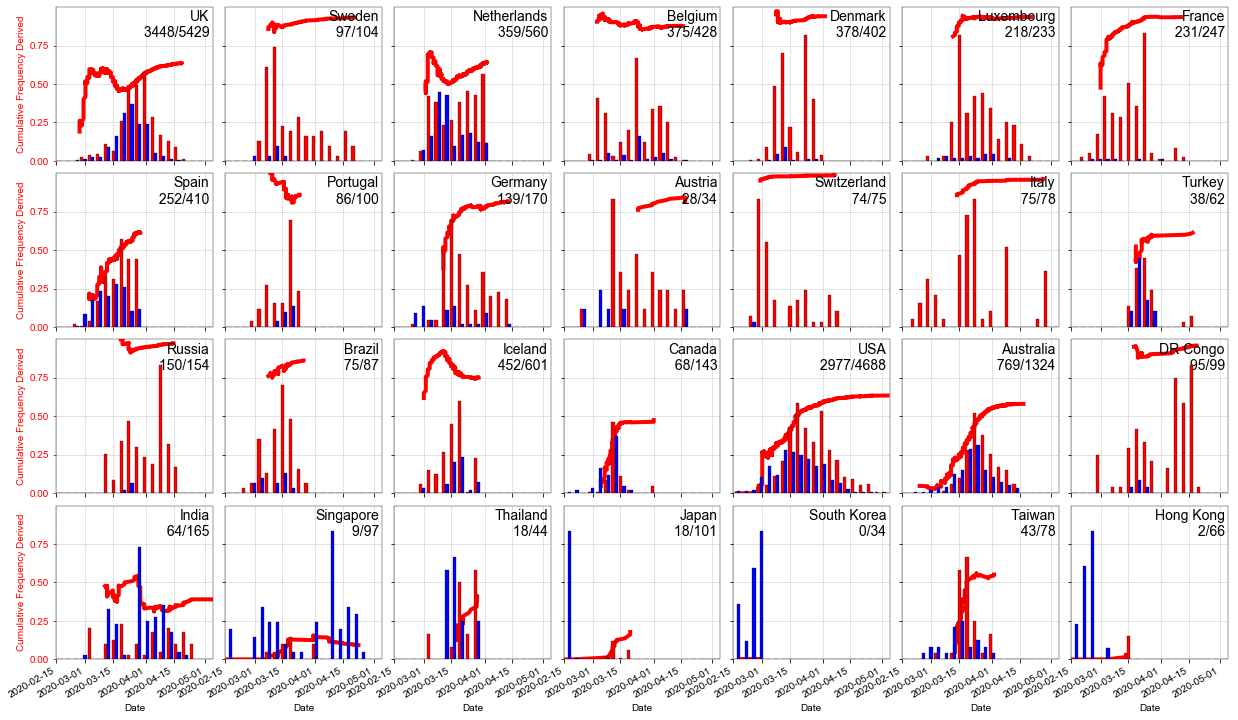

In [97]:
array_freqs(df=df2, pos="23402", flip=True,
            countries=countries, 
            xlim = [date(2020, 2, 15), date(2020, 5, 5)],
            txt_xy=(0.98, 0.98), #23402 #35
            n_row=4, n_col=7,
            fs_l=14, lw=4, c="red", cs=["red", "blue"], hist_bw=4,
            savepath="") # ./figures/dumpster/arr_countries.png

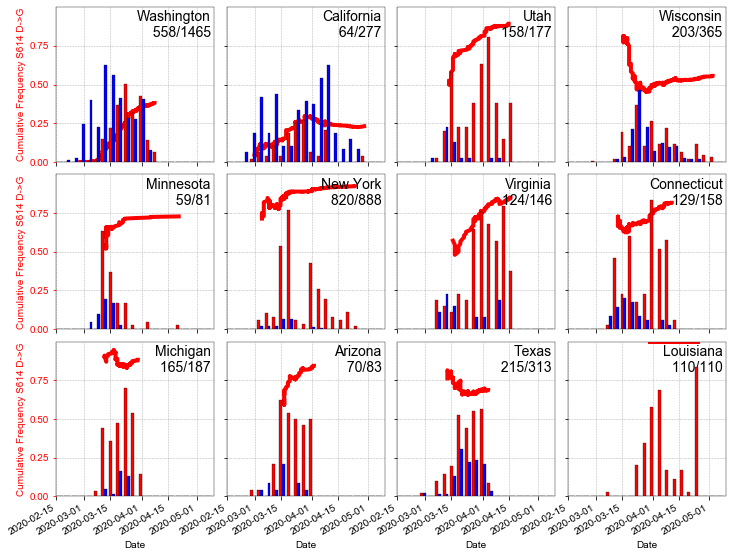

In [98]:
regions = ["Washington", "California", "Utah", "Wisconsin", 
           "Minnesota", "New York", "Virginia", "Connecticut", 
           "Michigan", "Arizona", "Texas", "Louisiana"]

array_freqs(df=df2, countries=regions, col="division", fs_l=14, lw=4, 
            xlim = [date(2020, 2, 15), date(2020, 5, 10)],
            pos="23402", flip=True,   #1058: US Mutation # 17857: Washington Mutation, # 23402
            c="red", cs=["red", "blue"], hist_bw=4,
            n_row = 3, n_col =4, txt_xy=(0.98, 0.98), only_first=False,
            ylabel="Cumulative Frequency S614 D->G",
            savepath="") # ./figures/dumpster/arr_us.png

In [92]:
df2["country"].value_counts()[:50]
#df2["division"].value_counts()[:50]

UK                      5429
USA                     4688
Australia               1324
Iceland                  601
Netherlands              560
Belgium                  428
China                    420
Spain                    410
Denmark                  402
France                   247
Luxembourg               233
Germany                  170
India                    165
Russia                   154
Canada                   143
Sweden                   104
Japan                    101
Portugal                 100
DR Congo                  99
Singapore                 97
Brazil                    87
Italy                     78
Taiwan                    78
Switzerland               75
Hong Kong                 66
Turkey                    62
Thailand                  44
Finland                   40
Greece                    37
Austria                   34
South Korea               34
Hungary                   32
Argentina                 29
Norway                    29
Czech Republic

### Plot UK

Saved to ./figures/dumpster/arr_uk.png


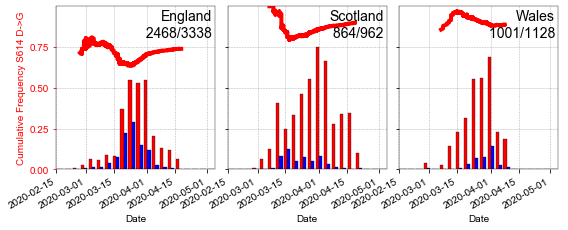

In [54]:
regions = ["England","Scotland", "Wales"]

array_freqs(df=df2, countries=regions, col="division", fs_l=14, lw=4, 
            xlim = [date(2020, 2, 15), date(2020, 5, 5)],
            pos="11082", # 23402
            c="red", cs=["red", "blue"], hist_bw=4,
            n_col =3, n_row = 1, txt_xy=(0.98, 0.98), only_first=False,
            ylabel="Cumulative Frequency S614 D->G",
            savepath="./figures/dumpster/arr_uk.png") # ./figures/dumpster/arr_us.png

# Check out Variants

In [52]:
df = pd.read_csv("./output/tables/variant_maf.tsv", sep="\t")

In [58]:
df.sort_values(by="maf", ascending=False)

,refcount,altcount,ref,alt,pos,totcount,maf
23,10889,6200,t,c,14407,17089,0.362806
14,10861,6175,t,c,3036,17036,0.362468
34,10921,6163,g,a,23402,17084,0.360747
4,10656,5907,t,c,240,16563,0.356638
39,12844,4251,g,t,25562,17095,0.248669
7,13402,3550,c,t,1058,16952,0.209415
53,13906,3109,g,a,28880,17015,0.182721
54,13932,3099,g,a,28881,17031,0.181962
55,13933,3099,g,c,28882,17032,0.181952
20,14754,2232,g,t,11082,16986,0.131402
